In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import VGG19

from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

# For reproducibility
np.random.seed(42)
from scipy import sparse


In [2]:
df = pd.read_csv('/content/drive/MyDrive/General Assembly/breast_cancer_project/no_dubs_train.csv')

cancer_only = df[df['cancer'] == 1]['patient_id'].tolist()
no_cancer_only = df[df['cancer'] == 0]['patient_id'].tolist()


In [3]:
MAX_IMAGE = 300

In [4]:
target_path = '/content/drive/MyDrive/General Assembly/breast_cancer_project/breast_imaging_340px/cancer'

list_of_dirs = [x for x in os.listdir(target_path)]
print(f'Total mammograms: {len(list_of_dirs)}')

image_count = 0
sparse_dir_cancer_list = []
count = 0
for dir_name in list_of_dirs:

  path = f'{target_path}/{dir_name}'
  for dirs in os.listdir(path):
    count += len(os.listdir(path))
    if count < 2400:
      continue

    image_count += 1
    sparse_dir_cancer_list.append(f'{path}/{dirs}')
    if image_count >= MAX_IMAGE:
      break
  if image_count >= MAX_IMAGE:
    break

print(len(sparse_dir_cancer_list))

Total mammograms: 486
226


In [5]:
MAX_IMAGE = 1800

In [18]:
target_path = '/content/drive/MyDrive/General Assembly/breast_cancer_project/breast_imaging_340px/no_cancer'

list_of_dirs = [x for x in os.listdir(target_path)]
print(f'Total mammograms: {len(list_of_dirs)}')

image_count = 0
sparse_dir_no_cancer_list = []
count = 0
for dir_name in list_of_dirs:

  path = f'{target_path}/{dir_name}'
  for dirs in os.listdir(path):
    count += len(os.listdir(path))
    if count < 11600:
      continue

    image_count += 1
    sparse_dir_no_cancer_list.append(f'{path}/{dirs}')
    if image_count >= MAX_IMAGE:
      break

  if image_count >= MAX_IMAGE:
    break

Total mammograms: 10292


In [19]:
def convert_image_to_rgb(arr):
  img2 = np.zeros( ( np.array(arr).shape[0], np.array(arr).shape[1], 3 ) )
  img2[:,:,0] = arr # same value in each channel
  img2[:,:,1] = arr
  img2[:,:,2] = arr

  return img2

X = []

for cancer_sparse_path in sparse_dir_cancer_list:
  sparse_matrix = sparse.load_npz(cancer_sparse_path)
  rgb_image = convert_image_to_rgb(sparse_matrix.todense())
  X.append(rgb_image)

for no_cancer_sparse_path in sparse_dir_no_cancer_list:
  sparse_matrix = sparse.load_npz(no_cancer_sparse_path)
  rgb_image = convert_image_to_rgb(sparse_matrix.todense())
  X.append(rgb_image)

X = np.array(X)

X.shape

(2026, 340, 340, 3)

In [20]:
y = [1] * 226 + [0] * 1800
y = np.array(y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


----

In [15]:

data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
  layers.RandomBrightness(
    0.4, value_range=(0, 255)
  ),
  layers.RandomContrast(
      0.4
  ),
  layers.RandomZoom(
      height_factor=0.4,
      width_factor=0.2,
      fill_mode='reflect',
      interpolation='bilinear',
      fill_value=0.0,
  )
])

model = Sequential()

model.add(layers.Input(shape=(500,500, 3)))

# First Convolution
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model.add(Flatten())

# Fully Connected
model.add(Dense(64, activation='relu'))
Dropout(rate=.4)

model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam',
              loss='bce',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping( patience = 4)

h = model.fit(
    X_train, 
    y_train, 
    epochs=32, 
    batch_size=64, 
    validation_data=(X_test, y_test), 
    callbacks = [es],
)


Epoch 1/32


In [ ]:
plt.plot(h.history['loss'], label = 'Train Loss')
plt.plot(h.history['val_loss'], label = 'Test Loss')
plt.legend();

-----

In [12]:
model_builder = Xception

xception = model_builder(
    include_top=False,
    weights="imagenet",
    input_shape=(340,340,3),
    classes=2,
    classifier_activation="softmax",
)

xception.trainable = False

model = Sequential()

# model.add(resize_and_rescale)
# model.add(data_augmentation)
model.add(xception)
model.add(layers.GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))


#Compile the model
model.compile(optimizer='adam',
              loss='bce',
              metrics=['acc'])

83683744/83683744 [==============================] - 0s 0us/step


In [13]:
es = EarlyStopping( patience = 4)


res = model.fit(
      X_train, 
      y_train, 
      epochs=32,
      validation_data = (X_test, y_test),
      callbacks = [es],
    )



Epoch 1/32
24/24 [==============================] - 41s 2s/step - loss: 0.6390 - acc: 0.6693 - val_loss: 0.6100 - val_acc: 0.6920
Epoch 2/32
24/24 [==============================] - 37s 2s/step - loss: 0.5804 - acc: 0.7120 - val_loss: 0.6001 - val_acc: 0.6560
Epoch 3/32
24/24 [==============================] - 36s 2s/step - loss: 0.5964 - acc: 0.6680 - val_loss: 0.6406 - val_acc: 0.6800
Epoch 4/32
24/24 [==============================] - 37s 2s/step - loss: 0.5963 - acc: 0.7080 - val_loss: 0.5888 - val_acc: 0.6840
Epoch 5/32
24/24 [==============================] - 37s 2s/step - loss: 0.5617 - acc: 0.7173 - val_loss: 0.6203 - val_acc: 0.6760
Epoch 6/32
24/24 [==============================] - 37s 2s/step - loss: 0.5581 - acc: 0.7280 - val_loss: 0.6079 - val_acc: 0.6760
Epoch 7/32
24/24 [==============================] - 37s 2s/step - loss: 0.5490 - acc: 0.7187 - val_loss: 0.5946 - val_acc: 0.6800
Epoch 8/32
24/24 [==============================] - 36s 2s/step - loss: 0.5561 - acc: 0.71

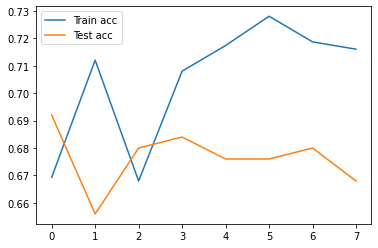

In [14]:
plt.plot(res.history['acc'], label = 'Train acc')
plt.plot(res.history['val_acc'], label = 'Test acc')
plt.legend();

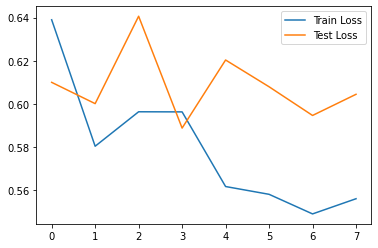

In [15]:
plt.plot(res.history['loss'], label = 'Train Loss')
plt.plot(res.history['val_loss'], label = 'Test Loss')
plt.legend();

In [27]:
model.save('/content/drive/MyDrive/General Assembly/breast_cancer_project/xception_model_v12.h5')

In [17]:
model = load_model('/content/drive/MyDrive/General Assembly/breast_cancer_project/xception_model_v12.h5')

In [22]:
es = EarlyStopping( patience = 4)


res = model.fit(
      X_train, 
      y_train, 
      epochs=32,
      validation_data = (X_test, y_test),
      callbacks = [es],
    )



Epoch 1/32
48/48 [==============================] - 77s 2s/step - loss: 0.2353 - acc: 0.9026 - val_loss: 0.3670 - val_acc: 0.8876
Epoch 2/32
48/48 [==============================] - 76s 2s/step - loss: 0.2416 - acc: 0.9085 - val_loss: 0.3275 - val_acc: 0.8895
Epoch 3/32
48/48 [==============================] - 75s 2s/step - loss: 0.2272 - acc: 0.9092 - val_loss: 0.3279 - val_acc: 0.8895
Epoch 4/32
48/48 [==============================] - 76s 2s/step - loss: 0.2307 - acc: 0.9184 - val_loss: 0.3764 - val_acc: 0.8876
Epoch 5/32
48/48 [==============================] - 75s 2s/step - loss: 0.2322 - acc: 0.9138 - val_loss: 0.3309 - val_acc: 0.8935
Epoch 6/32
48/48 [==============================] - 76s 2s/step - loss: 0.2125 - acc: 0.9190 - val_loss: 0.3720 - val_acc: 0.8876


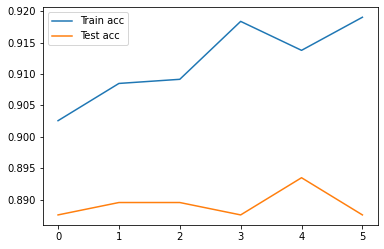

In [25]:
plt.plot(res.history['acc'], label = 'Train acc')
plt.plot(res.history['val_acc'], label = 'Test acc')
plt.legend();

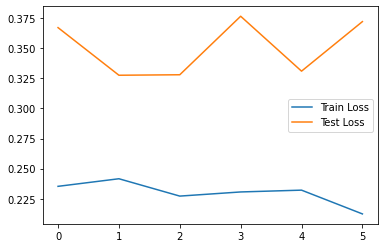

In [26]:
plt.plot(res.history['loss'], label = 'Train Loss')
plt.plot(res.history['val_loss'], label = 'Test Loss')
plt.legend();

-----


In [138]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

model_builder = ResNet50V2

resnet = model_builder(
    include_top=False,
    weights="imagenet",
    input_shape=(340,340,3),
    classes=2,
    classifier_activation="softmax",
)

resnet.trainable = False

model = Sequential()

# model.add(resize_and_rescale)
# model.add(data_augmentation)
model.add(resnet)
model.add(layers.GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))


#Compile the model
model.compile(optimizer='adam',
              loss='bce',
              metrics=['acc'])

es = EarlyStopping( patience = 4)


res = model.fit(
      X_train, 
      y_train, 
      epochs=32,
      validation_data = (X_test, y_test),
      callbacks = [es],
    )



94668760/94668760 [==============================] - 0s 0us/step
Epoch 1/32
48/48 [==============================] - 65s 1s/step - loss: 0.4961 - acc: 0.8769 - val_loss: 0.3476 - val_acc: 0.8876
Epoch 2/32
48/48 [==============================] - 59s 1s/step - loss: 0.3761 - acc: 0.8848 - val_loss: 0.3441 - val_acc: 0.8876
Epoch 3/32
48/48 [==============================] - 58s 1s/step - loss: 0.3486 - acc: 0.8881 - val_loss: 0.3442 - val_acc: 0.8876
Epoch 4/32
48/48 [==============================] - 60s 1s/step - loss: 0.3413 - acc: 0.8881 - val_loss: 0.3452 - val_acc: 0.8876
Epoch 5/32
 3/48 [>.............................] - ETA: 43s - loss: 0.3657 - acc: 0.8750

KeyboardInterrupt: ignored

In [ ]:
plt.plot(res.history['acc'], label = 'Train acc')
plt.plot(res.history['val_acc'], label = 'Test acc')
plt.legend();

In [ ]:
plt.plot(res.history['loss'], label = 'Train Loss')
plt.plot(res.history['val_loss'], label = 'Test Loss')
plt.legend();

In [ ]:
pred_proba = model.predict(X_test)

predict_classes=np.argmax(pred_proba,axis=1)

for pred in pred_proba:
  print(f"{pred}")

5/5 [==============================] - 0s 91ms/step
[0.43822467]
[0.48038766]
[0.44427723]
[0.46240523]
[0.45121667]
[0.44809723]
[0.4420055]
[0.44091988]
[0.4310834]
[0.43709818]
[0.49366975]
[0.4440891]
[0.47765055]
[0.43762347]
[0.44737825]
[0.4485166]
[0.44496188]
[0.4838089]
[0.44289675]
[0.49923477]
[0.4338071]
[0.44436893]
[0.44287506]
[0.45930004]
[0.45193276]
[0.43665296]
[0.45179492]
[0.45133188]
[0.44879323]
[0.43572345]
[0.51881444]
[0.43682563]
[0.46796617]
[0.46014595]
[0.46051133]
[0.4772837]
[0.44022667]
[0.44675288]
[0.43722957]
[0.44259727]
[0.4632535]
[0.5018103]
[0.4445398]
[0.45204693]
[0.43668178]
[0.44625536]
[0.49605855]
[0.4633948]
[0.5003043]
[0.44748148]
[0.4649119]
[0.48579675]
[0.47306094]
[0.45045564]
[0.4339988]
[0.43294463]
[0.46226773]
[0.46937743]
[0.44921964]
[0.50399375]
[0.4619536]
[0.44105545]
[0.47609586]
[0.43903655]
[0.44144315]
[0.4654749]
[0.4417086]
[0.43084744]
[0.46834463]
[0.46762913]
[0.44513905]
[0.45235682]
[0.46587786]
[0.43740445]
[0.

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
for score in scores:
  print(f"{model.metrics_names[0]}: {round(score*100, 2)}%")

loss: 69.85%
loss: 50.67%
